# Deep Learning - **Homework #3**

* Teching assistant email: trung@uef.fi
* Deadline: **23:59 - 14/12/2019 (UPDATED)**
* Maximum: **3 points**

Goals:

* Understand the important role of "randomization" in machine learning.
* Implement Radial Basis Function using your first customized `keras.layers.Layer` or `torch.nn.Module`.
* Admire Darwin and his theory with genetic algorithm and evolution strategy.

References:

1. Glorot, X., Bengio, Y., n.d. ["Understanding the difﬁculty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 8.
2. Broomhead, D. S.; Lowe, David (1988). ["Radial basis functions, multi-variable functional interpolation and adaptive networks"](http://www.dtic.mil/cgi-bin/GetTRDoc?AD=ADA196234) (Technical report).
3. Ha, David, 2017. ["A Visual Guide to Evolution Strategies"](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/).

How to submit:

* Option#1: **File** $\to$ **Download .ipynb** $\to$ _Send to .ipynb file to my email, or submit it to moodle page_.
* Option#2: **Share** read-only notebook link to my email.
* _If you choose to share the notebook, please re-name the notebook to your student name and student number, I will take the snapshot of your notebook before the deadline, any modification afterward will be disregarded._

**NOTE**: This is official homework and will be graded

In [0]:
# All libraries we use for this HW, run this block first!
import os
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(8)
torch.manual_seed(8)

X_digit, y_digit = load_digits(return_X_y=True)
X_digit_train, X_digit_test, y_digit_train, y_digit_test = train_test_split(X_digit, y_digit, test_size=0.3)

# Question 1: A good initialization is the one that you never know


![alt text](https://drive.google.com/uc?export=view&id=15bvT51OngFUT96ru24IymHRyt2wBZVly)

The above figure illustrate the `crossentropy` loss surface in relation to the parameters of the network $W_1$ and $W_2$.

As you can see, by just randomly picking the initial values for the weights, we could land right at the optimum position.

With this _mindset_, answer question **a)** and **b)**

### **a)** Every randomization is _"equal"_, but some are more _"equal"_ than the others.

The back-propagated gradients were smaller as one moves away from the output layer [1]. 

As a result, the normalization factor may therefore be important when
initializing deep networks because of the multiplicative effect through layers [1]. 

A **normalized initialization** is proposed to maintain activation variances and back-propagated gradients variance as one moves up or down the network [1]. 

> In short, using equation **(16)** in the paper [1] to implement the normalized initialization in following code block.

**[1]** Glorot, X., Bengio, Y., n.d. [Understanding the difﬁculty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 8.


In [0]:
def Uniform(tensor, a=0., b=1.):
  # tensor: torch.Tensor object
  with torch.no_grad():
    return tensor.uniform_(a, b)


def NormalizedUniform(tensor):
  # tensor: torch.Tensor object
  # TODO: finish the implementation of NormalizedUniform initialization
  with torch.no_grad():
    return tensor.uniform_(a, b)

Trained 5 different models with `Uniform` initialization
Trained 10 different models with `Uniform` initialization
Trained 5 different models with `NormalizedUniform` initialization
Trained 10 different models with `NormalizedUniform` initialization


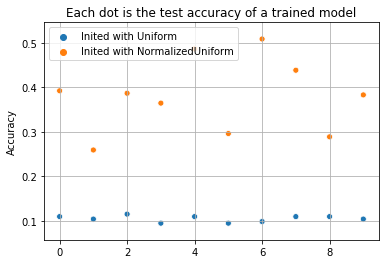

In [0]:
#@title Run the following code block to debug your initializer
def repeat_train_model(init_class):
  uniform_acc = []
  for i in range(10):
    model = torch.nn.Sequential(torch.nn.Linear(X_digit.shape[1], 64),
                                torch.nn.ReLU(), torch.nn.Linear(64, 64),
                                torch.nn.ReLU(), torch.nn.Linear(64, 10),
                                torch.nn.Softmax(dim=1))
    for module in model.modules():
      if hasattr(module, 'weight'):
        init_class(module.weight)
    # training
    opt = torch.optim.Adam(model.parameters())
    loss_func = torch.nn.modules.loss.NLLLoss()
    for epoch in range(10):
      for start in range(0, X_digit_train.shape[0], 512):
        x_ = torch.from_numpy(X_digit_train[start:start +
                                            512].astype('float32'))
        y_ = torch.from_numpy(y_digit_train[start:start + 512])
        opt.zero_grad()
        loss = loss_func(model(x_), y_)
        loss.backward()
        opt.step()
    # evaluating
    y_test_pred = np.argmax(model(
        torch.from_numpy(X_digit_test.astype('float32'))).detach().numpy(),
                            axis=-1)
    test_acc = accuracy_score(y_digit_test, y_test_pred)
    uniform_acc.append(test_acc)
    if (i + 1) % 5 == 0:
      print("Trained %d different models with `%s` initialization" %
            ((i + 1), init_class.__name__))
  return uniform_acc


uniform_acc = repeat_train_model(Uniform)
normuniform_acc = repeat_train_model(NormalizedUniform)
n = len(uniform_acc)
sns.scatterplot(x=list(range(n)) + list(range(n)),
                y=uniform_acc + normuniform_acc,
                hue=['Inited with Uniform'] * n +
                ['Inited with NormalizedUniform'] * n)
plt.grid(True)
plt.ylabel('Accuracy')
_ = plt.title("Each dot is the test accuracy of a trained model")

### **b)** Are every problem could be solved by repeating different initialization until you get the optimum solution?

# Question 2: Radial Basis Function (RBF)

The RBF neural networks implement the function:

$s(x) = b_0 + \sum_i^Mw_i\Phi\big( ||\vec{x} - \vec{c_i}|| \big) \tag{1}$

where:

* $b_0 \in \Re$ is the bias term 
* $w_i \in \Re$ is the weight value for neuron unit $i^{th}$
* $\vec{x} \in \Re^N$ is the input vector
* $\vec{c_i} \in \Re^N$ is the center of neuron unit $i^{th}$

The basis function

$\Phi(||\vec{x} - \vec{c_i}||) = exp\big(-\frac{||\vec{x} - \vec{c_i}||^2}{\beta^2}\big) \tag{2}$

and $||\vec{x} - \vec{c_i}|| = \sqrt{\sum(\vec{x} - \vec{c_i})^2}$

Design a RBF to approximate the following function:

$y = sin(x) \times cos(x), \text{ } 0 \leq x \leq 2\pi \tag{3}$





### **a)** Finish the following function to generate training and testing data for the RBF.

In [0]:
def generate_data(num_data_points=1000):
  # TODO: generate your data (x, y) pair here (using Eq (3))

x, y = generate_data()
assert x.ndim == 2, "Your input must be 2-D"
assert y.ndim == 1, "Your target must be 1-D"
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

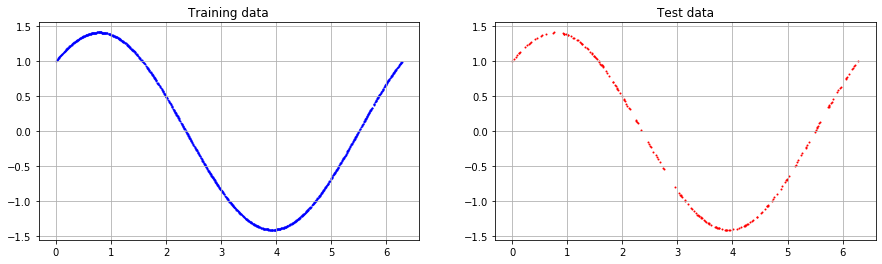

In [0]:
#@title Run this blog to debug your data generation
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, c='b', s=1)
plt.grid(True)
plt.title("Training data")
plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test, c='r', s=1)
plt.grid(True)
_ = plt.title("Test data")

### **b)** Finish the implementation of the `RadialBasisFunction` class

Did your *RBF* fit the data? (i.e. it provides a sinusoid curve in the prediction)

If not, could you explain why? (_Hint_: again the initialization is important)

In [0]:
class RadialBasisFunction(torch.nn.Module):

  def __init__(self, input_dim, units, center_initializer=None, beta=1.0):
    super().__init__()
    self.units = int(units)
    self.beta = beta
    self.center_initializer = center_initializer
    # ====== initialize the parameters ====== #
    # TODO: initialize the weight, center and bias for RBF here

  def forward(self, inputs):
    # need to expand dims to make inputs broadcastable to the center
    # We have something like these:
    # * inputs [batch_size, input_dim] -> [batch_size, 1, input_dim]
    # * center [units, input_dims]
    # * inputs-center [batch_size, units, input_dims]
    # * radius [batch_size, units]
    # TODO: using Eq (1) and (2) finish the calculation of RBF
    inputs = torch.from_numpy(inputs)
    inputs = 
    radius = 
    beta = torch.tensor(self.beta, dtype=inputs.dtype)
    # [batch_size, units]
    outputs = 
    # [batch_size,]
    outputs = torch.sum(outputs + self.bias, dim=-1)
    return outputs

In [0]:
# run this block to create your rbf, you might modify it as necessary
rbf = RadialBasisFunction(input_dim=x_train.shape[1],
                          units=8,
                          beta=1.0)

Epoch#4  Loss:0.2897
Epoch#9  Loss:0.2082
Epoch#14  Loss:0.1448
Epoch#19  Loss:0.0983
Epoch#24  Loss:0.0670
Epoch#29  Loss:0.0478
Epoch#34  Loss:0.0366
Epoch#39  Loss:0.0299
Epoch#44  Loss:0.0251
Epoch#49  Loss:0.0212
Epoch#54  Loss:0.0180
Epoch#59  Loss:0.0155
Epoch#64  Loss:0.0135
Epoch#69  Loss:0.0119
Epoch#74  Loss:0.0104
Epoch#79  Loss:0.0091
Epoch#84  Loss:0.0079
Epoch#89  Loss:0.0069
Epoch#94  Loss:0.0061
Epoch#99  Loss:0.0054
Test Loss: 0.005560545685456137


Text(0.5, 1.0, 'Predicted test data')

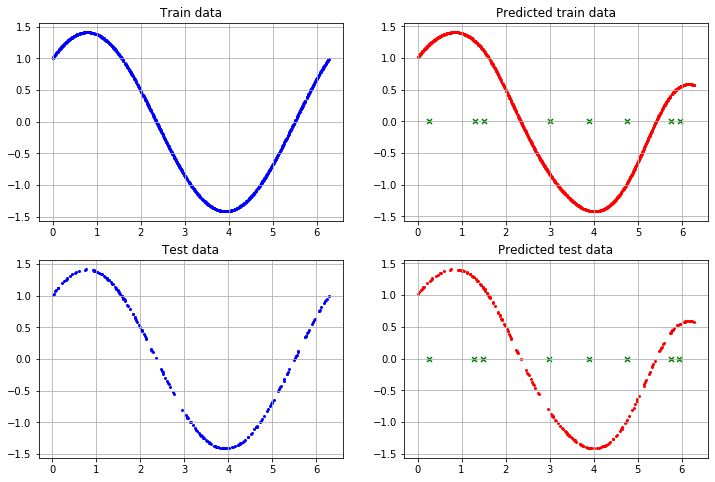

In [0]:
#@title Run the following code blog to use backpropagation training your rbf and debug it (NOTE: the green cross is the center of each neuron unit)
fn_loss = torch.nn.MSELoss(reduction='mean')
opt = torch.optim.Adam(params=rbf.parameters(), lr=0.01)
for epoch in range(100):
  opt.zero_grad()
  y_train_pred = rbf(x_train)
  loss = fn_loss(torch.from_numpy(y_train), y_train_pred)
  loss.backward()
  opt.step()
  if (epoch + 1) % 5 == 0:
    print("Epoch#%d  Loss:%.4f" % (epoch, loss))

y_test_pred = rbf(x_test)
test_loss = fn_loss(torch.from_numpy(y_test), y_test_pred)
print("Test Loss:", test_loss.detach().numpy())

y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.title("Predicted test data")

# Question 3: Use genetic algorithm to train the network of Radial Basis Function.

![alt text](https://drive.google.com/uc?export=view&id=1XSFo1Ep5w0lll5_r3XewSxvDHhLPmxwT)

The above flow chart describes the genetic algorithm and the purpose of each function you have to implement in **a)**, **b)** and **c)** (only the `TODO` places)

### **a)** Finish the implementation of all essential functions for GA

In [0]:
def initialze_population(units, input_shape, size=100):
  population = []
  for i in range(int(size)):
    # TODO
  return population

def mutate(rbf, mean=0., stddev=1., mutation_rate=0.1):
  # concatenate all parameters into single vector, easier to handle
  params = torch.cat([
      torch.reshape(rbf.weight, [-1]),
      torch.reshape(rbf.center, [-1]), rbf.bias
  ], dim=0)
  # TODO

def crossover(rbf1, rbf2):
  rbf = RadialBasisFunction(x_train.shape[1], rbf1.units)
  # concatenate all parameters into single vector, easier to handle
  params1 = torch.cat([
      torch.reshape(rbf1.weight, [-1]),
      torch.reshape(rbf1.center, [-1]), rbf1.bias
  ],
                      dim=0)
  params2 = torch.cat([
      torch.reshape(rbf2.weight, [-1]),
      torch.reshape(rbf2.center, [-1]), rbf2.bias
  ],
                      dim=0)
  # new params inherit from both mum and dad
  new_params = (params1 + params2) / 2
  with torch.no_grad():
    rbf.weight.data = torch.reshape(new_params[:rbf.units],
                                    rbf.weight.shape).data
    rbf.center.data = torch.reshape(new_params[rbf.units:-1],
                                    rbf.center.shape).data
    rbf.bias.data = torch.reshape(new_params[-1], rbf.bias.shape).data
  return rbf


def select(x_train,
           y_train,
           population,
           n_best=20,
           loss_func=torch.nn.MSELoss()):
  # TODO
  # note: this function has to return both a list of best candidates and best losses
  return

### **b)** Writing the training procedure for Genetic algorithm

In [0]:
def genetic_algorithm(crossover_func=crossover,
                      n_generation=80,
                      population_size=80,
                      n_best=20):
  population = initialze_population(8,
                                    input_shape=(None, 1),
                                    size=population_size)
  history = []
  best_rbf = None
  for generation in range(n_generation):
    best_candidates, best_losses = select(x_train,
                                          y_train,
                                          population,
                                          n_best=n_best)
    best_losses = np.asarray(best_losses)
    # The parents will be selected based how good they are,
    # determine the probabilities of each candidate here.
    # TODO: assign appropriate probabilities for each candidate
    candidates_probabilities = 

    # crossover create a new off-spring with mutation
    new_population = []
    for i in range(population_size):
      # TODO: add code here to finish the process of generate new population
      new_population.append(offspring)
    population = new_population
    
    # since losses is sorted in ascending order, the first one is the smallest
    # (i.e. the best) loss value
    if (generation + 1) % 5 == 0:
      print("Generation#%d  Loss:%.4f" % (generation + 1, best_losses[0]))
    history.append(best_losses[0])
    if best_losses[0] <= np.min(history):
      best_rbf = best_candidates[0]
  plt.figure()
  plt.plot(history)
  plt.title("Training Loss")
  return best_rbf

Generation#5  Loss:0.4964
Generation#10  Loss:0.4106
Generation#15  Loss:0.4042
Generation#20  Loss:0.3674
Generation#25  Loss:0.3349
Generation#30  Loss:0.3495
Generation#35  Loss:0.3531
Generation#40  Loss:0.3532
Generation#45  Loss:0.3535
Generation#50  Loss:0.3538
Generation#55  Loss:0.3403
Generation#60  Loss:0.3537
Generation#65  Loss:0.3532
Generation#70  Loss:0.3486
Generation#75  Loss:0.3494
Generation#80  Loss:0.3487


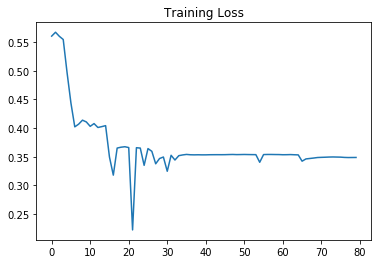

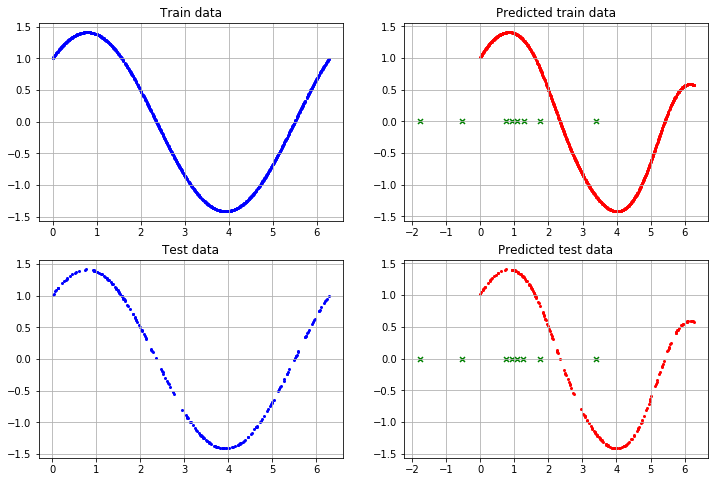

In [0]:
#@title Run this code block to debug your genetic algorithm
rbf = genetic_algorithm()
assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")

### **c)** Something wrong with `crossover` function, could you fix it? Finish the implementation of `crossover_new`

**NOTE**: if the first `crossover` function is right, then Darwin must be wrong. 

In [0]:
def crossover_new(rbf1, rbf2):
  rbf = RadialBasisFunction(x_train.shape[1], rbf1.units)
  # TODO: finish the crossover_new and return new rbf offspring

Generation#5  Loss:0.5558
Generation#10  Loss:0.3424
Generation#15  Loss:0.0744
Generation#20  Loss:0.0657
Generation#25  Loss:0.0651
Generation#30  Loss:0.0629
Generation#35  Loss:0.0629
Generation#40  Loss:0.0623
Generation#45  Loss:0.0622
Generation#50  Loss:0.0620
Generation#55  Loss:0.0619
Generation#60  Loss:0.0616
Generation#65  Loss:0.0596
Generation#70  Loss:0.0596
Generation#75  Loss:0.0596
Generation#80  Loss:0.0595


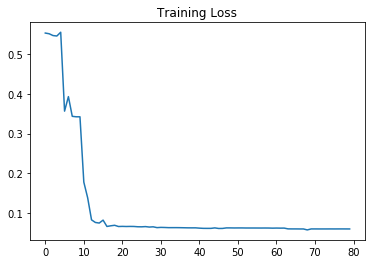

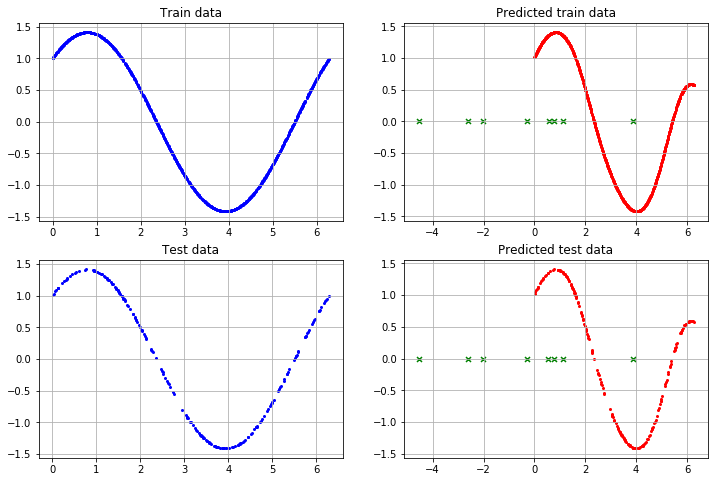

In [0]:
#@title Run this code block to debug your `crossover_new` function
rbf = genetic_algorithm(crossover_func=crossover_new)
assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.detach().numpy().ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")